In [1]:
# set up
import pandas as pd

In [2]:
# load the merged data
merged_data = pd.read_csv("merged_data.csv")

# show it
print(merged_data.head(5))

   Unnamed: 0 Company     Location  # Laid Off      Date_x   %  Industry  \
0           0     AMD  SF Bay Area      1000.0  11/13/2024  4%  Hardware   
1           1     AMD  SF Bay Area      1000.0  11/13/2024  4%  Hardware   
2           2     AMD  SF Bay Area      1000.0  11/13/2024  4%  Hardware   
3           3     AMD  SF Bay Area      1000.0  11/13/2024  4%  Hardware   
4           4     AMD  SF Bay Area      1000.0  11/13/2024  4%  Hardware   

                   Source     Stage $ Raised        Country  Date Added  \
0  https://www.techope...  Post-IPO  $1,600   United States  11/13/2024   
1  https://www.techope...  Post-IPO  $1,600   United States  11/13/2024   
2  https://www.techope...  Post-IPO  $1,600   United States  11/13/2024   
3  https://www.techope...  Post-IPO  $1,600   United States  11/13/2024   
4  https://www.techope...  Post-IPO  $1,600   United States  11/13/2024   

  tickers      Date_y      Value  
0     AMD  2021-01-04  92.300003  
1     AMD  2021-01-05 

C:\Users\27311\AppData\Local\Temp\ipykernel_26216\4039409213.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_data = pd.read_csv("merged_data.csv")


In [3]:
# calculate daily yield
merged_data['Daily_Return'] = merged_data.groupby('Company')['Value'].pct_change()

# change the date time type
merged_data['Date_x'] = pd.to_datetime(merged_data['Date_x'])
merged_data['Date_y'] = pd.to_datetime(merged_data['Date_y'])

# note the layoff day
merged_data['Layoff_Event'] = (merged_data['Date_y'] == merged_data['Date_x']).astype(int)

# Create the event window (before and after 10 days)
merged_data['Event_Window'] = ((merged_data['Date_y'] >= (merged_data['Date_x'] - pd.Timedelta(days = 10))) & 
                               (merged_data['Date_y'] <= (merged_data['Date_x'] - pd.Timedelta(days = 10)))).astype(int)

C:\Users\27311\AppData\Local\Temp\ipykernel_26216\1945041358.py:2: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  merged_data['Daily_Return'] = merged_data.groupby('Company')['Value'].pct_change()


In [4]:
# OLS Regression
import statsmodels.api as sm

merged_data['$ Raised'] = merged_data['$ Raised'].replace(r'[\$,]', '', regex=True).astype(float)
merged_data['# Laid Off'] = merged_data['# Laid Off'].astype(float)

merged_data = merged_data.dropna(subset=['Daily_Return', 'Layoff_Event', '# Laid Off', '$ Raised'])

control_vars = ['# Laid Off', '$ Raised']

X = merged_data[['Layoff_Event']+control_vars]

X = sm.add_constant(X)

y = merged_data['Daily_Return']

ols_model_1 = sm.OLS(y, X).fit()

print(ols_model_1.summary())


                            OLS Regression Results                            
Dep. Variable:           Daily_Return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1523
Date:                Mon, 09 Dec 2024   Prob (F-statistic):              0.928
Time:                        14:32:01   Log-Likelihood:            -6.0495e+05
No. Observations:              363466   AIC:                         1.210e+06
Df Residuals:                  363462   BIC:                         1.210e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0082      0.002      3.525   

From the results above we can tell：

1.R-squared and Adjusted R-squared:

R-squared is 0.000 and Adjusted R-squared is -0.000, indicating that the model’s explanatory power on the dependent variable (Daily_Return) is almost zero.
In other words, Layoff_Event and the control variables (# Laid Off, $ Raised) have little explanatory power on changes in daily returns.


2.F-statistic and Prob (F-statistic):

The p-value of F-statistic (Prob (F-statistic)) is 0.928, indicating that the overall model is not significant, and all independent variables combined have no significant explanation for the dependent variable.iable.

In [44]:
import matplotlib.pyplot as plt


In [20]:
# 找到非数值的行
invalid_rows = merged_data[~merged_data['%'].str.contains(r'^\d+%$', na=False)]
print(invalid_rows)



       Unnamed: 0     Company Location  # Laid Off     Date_x       %  \
76380       76380   LegalZoom   Austin       100.0 2023-10-19   Legal   
76381       76381   LegalZoom   Austin       100.0 2023-10-19   Legal   
76382       76382   LegalZoom   Austin       100.0 2023-10-19   Legal   
76383       76383   LegalZoom   Austin       100.0 2023-10-19   Legal   
76384       76384   LegalZoom   Austin       100.0 2023-10-19   Legal   
...           ...         ...      ...         ...        ...     ...   
83410       83410  Stitch Fix   Dallas       558.0 2023-10-09  Retail   
83411       83411  Stitch Fix   Dallas       558.0 2023-10-09  Retail   
83412       83412  Stitch Fix   Dallas       558.0 2023-10-09  Retail   
83413       83413  Stitch Fix   Dallas       558.0 2023-10-09  Retail   
83414       83414  Stitch Fix   Dallas       558.0 2023-10-09  Retail   

      Industry                       Source     Stage  $ Raised  \
76380    Legal  https://www.bizjournals.com  Post-IPO   

In [22]:
# 删除非数值的行
merged_data = merged_data[merged_data['%'].str.contains(r'^\d+%$', na=False)]


In [24]:
# 将非法值替换为默认值（如 '0%'）
merged_data['%'] = merged_data['%'].apply(lambda x: x if isinstance(x, str) and '%' in x else '0%')


In [26]:
merged_data['Layoff_Percentage'] = merged_data['%'].str.replace('%', '').astype(float)


In [104]:
import pandas as pd
from datetime import timedelta

# 确定三个月时间窗口
three_months_window = pd.Timedelta(days=90)

merged_data['Date_y'] = pd.to_datetime(merged_data['Date_y'])



In [110]:
def calculate_cumulative_return(group):
    group['Cumulative_Return_3M'] = group.loc[
        group['Date_y'] <= group['Date_y'].min() + three_months_window, 'Daily_Return'
    ].cumsum()
    return group

merged_data = merged_data.groupby('tickers').apply(calculate_cumulative_return)

C:\Users\27311\AppData\Local\Temp\ipykernel_26216\2265164887.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged_data = merged_data.groupby('tickers').apply(calculate_cumulative_return)


In [28]:
# 计算累积收益率
merged_data['Cumulative_Return'] = merged_data.groupby('tickers')['Daily_Return'].cumsum()


# 自变量：扩展后的裁员事件变量、裁员比例、行业和时间虚拟变量
control_vars2 = ['Layoff_Percentage']
# 删除自变量和因变量中的缺失值
merged_data = merged_data.dropna(subset=['Cumulative_Return', 'Event_Window'] + control_vars2)
X2 = merged_data[['Event_Window'] + control_vars2]
X2 = sm.add_constant(X2)

# 因变量：累积收益率或每日收益率
y2 = merged_data['Cumulative_Return']  # 或者 'Daily_Return'

# 回归模型
ols_model2 = sm.OLS(y2, X2).fit()

# 输出结果
print(ols_model2.summary())


                            OLS Regression Results                            
Dep. Variable:      Cumulative_Return   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                 1.110e+04
Date:                Mon, 09 Dec 2024   Prob (F-statistic):               0.00
Time:                        14:32:27   Log-Likelihood:            -2.1781e+06
No. Observations:              361457   AIC:                         4.356e+06
Df Residuals:                  361454   BIC:                         4.356e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -5.6705      0.21

#### **Constant Term (`const`)**

*   **Coefficient**: -5.6785, indicating that when all independent variables are set to 0, the baseline value of `Cumulative_Return` is -5.6785.
*   **Significance (p-value)**: p < 0.05, showing that the constant term is statistically significant.

#### **Event Window (`Event_Window`)**

*   **Coefficient**: -0.9189, indicating that within the event window, `Cumulative_Return` decreases by an average of 0.9189.
*   **Significance (p-value)**: p = 0.904, greater than 0.05, suggesting that `Event_Window` does not have a statistically significant effect on cumulative returns.
*   **Explanation**: The impact of the event window may require further adjustment to the time window or the addition of more control variables for more precise evaluation.

#### **Layoff Percentage (`Layoff_Percentage`)**

*   **Coefficient**: 1.9291, indicating that for every 1% increase in the layoff percentage, `Cumulative_Return` increases by an average of 1.9291.
*   **Significance (p-value)**: p < 0.05, showing a statistically significant effect on the dependent variable.
*   **Explanation**: The layoff percentage is significantly positively correlated with cumulative returns, possibly reflecting that investors view layoffs as a signal of cost reduction and efficiency improvement for companies.

In [30]:
quarter_list = [q for q in merged_data.columns if 'Quarter' in q]

merged_data = merged_data.drop(columns = quarter_list)

industry_list = [i for i in merged_data.columns if 'Industry' in i]

merged_data = merged_data.drop(columns = industry_list)



In [32]:
# 将日期列转换为年份和季度
merged_data['Quarter_Continuous'] = merged_data['Date_y'].dt.year.astype(str) + merged_data['Date_y'].dt.quarter.astype(str)

# 将季度变量转换为数值类型
merged_data['Quarter_Continuous'] = merged_data['Quarter_Continuous'].astype(int)

# 检查结果
print(merged_data[['Date_y', 'Quarter_Continuous']].head())


      Date_y  Quarter_Continuous
1 2021-01-05               20211
2 2021-01-06               20211
3 2021-01-07               20211
4 2021-01-08               20211
5 2021-01-11               20211


In [34]:
'''
does the timing of these layoff announcements (e.g., during quarterly earnings releases or market downturns) 
influence their effect on stock price performance?
'''
# 自变量：扩展后的裁员事件变量、裁员比例、行业和时间虚拟变量
control_vars3 = ['Layoff_Percentage', 'Quarter_Continuous']

# 删除自变量和因变量中的缺失值
merged_data = merged_data.dropna(subset=['Cumulative_Return', 'Event_Window'] + control_vars3)
X3 = merged_data[['Event_Window'] + control_vars3]
X3 = sm.add_constant(X3)

y3 = y2

In [36]:
# run the third model
ols_model3 = sm.OLS(y3, X3).fit()

print(ols_model3.summary())

                            OLS Regression Results                            
Dep. Variable:      Cumulative_Return   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     7405.
Date:                Mon, 09 Dec 2024   Prob (F-statistic):               0.00
Time:                        14:32:36   Log-Likelihood:            -2.1780e+06
No. Observations:              361457   AIC:                         4.356e+06
Df Residuals:                  361453   BIC:                         4.356e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1263.8591    308

In [114]:
# 再用'Cumulative_Return_3M'跑个回归

control_vars4 = ['Layoff_Percentage', 'Quarter_Continuous']

# 删除自变量和因变量中的缺失值
merged_data = merged_data.dropna(subset=['Cumulative_Return_3M', 'Event_Window'] + control_vars4)
X4 = merged_data[['Event_Window'] + control_vars4]
X4 = sm.add_constant(X4)

y4 = merged_data['Cumulative_Return_3M']

In [116]:
# run the fourth model
ols_model4 = sm.OLS(y4, X4).fit()

print(ols_model4.summary())

                             OLS Regression Results                             
Dep. Variable:     Cumulative_Return_3M   R-squared:                       0.059
Model:                              OLS   Adj. R-squared:                  0.059
Method:                   Least Squares   F-statistic:                     699.0
Date:                  Mon, 09 Dec 2024   Prob (F-statistic):          3.38e-295
Time:                          15:54:14   Log-Likelihood:            -1.3550e+05
No. Observations:                 22370   AIC:                         2.710e+05
Df Residuals:                     22367   BIC:                         2.710e+05
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const           

In [118]:
# 获取预测值和实际值
y_pred = ols_model4.predict(X4)
y_actual = y4

X_axis = merged_data['Quarter_Continuous']


C:\Users\27311\AppData\Local\Temp\ipykernel_26216\2755725973.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\27311\AppData\Local\Temp\ipykernel_26216\2755725973.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axins.scatter(


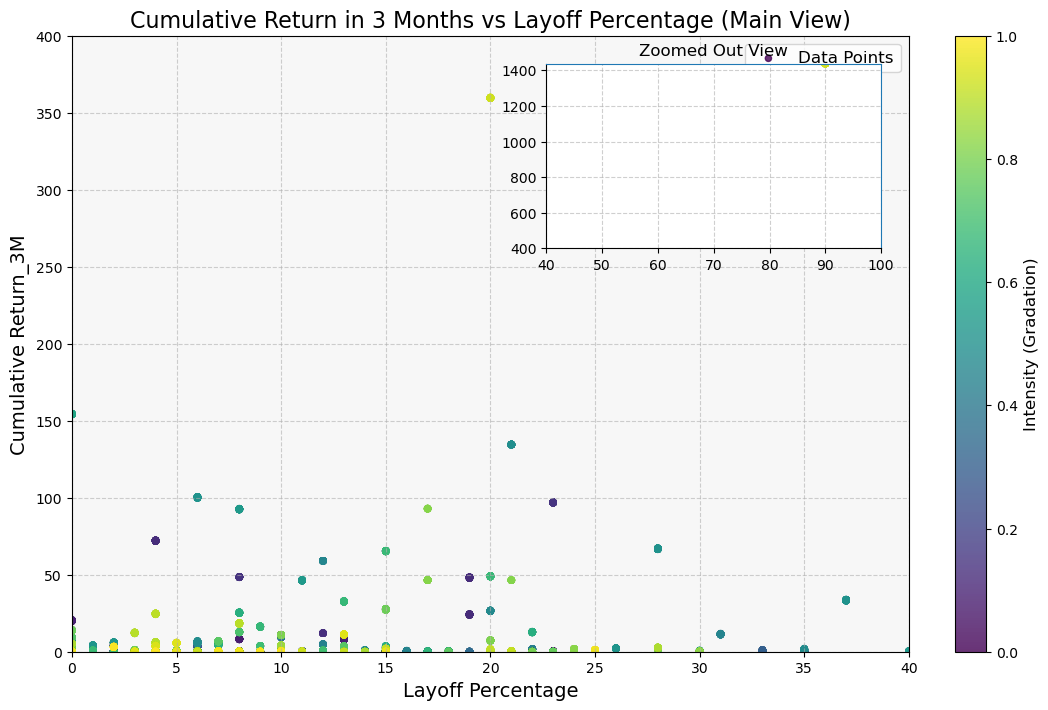

In [155]:
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# 主图范围设置
layoff_limit = 40
return_limit = 400

# 设置渐变背景
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_facecolor('#f7f7f7')  # 背景颜色为浅灰色
plt.grid(True, linestyle='--', alpha=0.6)  # 添加柔和的网格线

# 创建渐变散点颜色
scatter_colors = plt.cm.viridis(np.linspace(0, 1, len(merged_data['Layoff_Percentage'])))

# 主图：限制在 Layoff_Percentage <= 40 和 Cumulative_Return <= 400
scatter = ax.scatter(
    merged_data['Layoff_Percentage'], y4, 
    alpha=0.8, s=20, c=scatter_colors, cmap='viridis', label='Data Points'
)
# ax.plot(
#     merged_data['Layoff_Percentage'], y_pred, 
#     color='#1f78b4', linewidth=1, label='Regression Line'  # 配合散点的深蓝色
# )

# 设置主图范围
plt.xlim(0, layoff_limit)
plt.ylim(0, return_limit)

plt.xlabel('Layoff Percentage', fontsize=14)
plt.ylabel('Cumulative Return_3M', fontsize=14)
plt.title('Cumulative Return in 3 Months vs Layoff Percentage (Main View)', fontsize=16)
plt.legend(fontsize=12)

# 嵌套窗口：显示超出范围的点
axins = inset_axes(ax, width="40%", height="30%", loc='upper right', borderpad=2)
axins.scatter(
    merged_data['Layoff_Percentage'], y4, 
    alpha=0.8, s=20, c=scatter_colors, cmap='viridis'
)
axins.plot(
    merged_data['Layoff_Percentage'], y_pred, 
    color='#1f78b4', linewidth=2
)

# 设置小窗口的范围
axins.set_xlim(layoff_limit, max(merged_data['Layoff_Percentage']))
axins.set_ylim(return_limit, max(y4))

# 小窗口标题和样式
axins.set_title('Zoomed Out View', fontsize=12)
axins.grid(True, linestyle='--', alpha=0.6)
axins.spines['top'].set_color('#1f78b4')  # 设置小窗口边框颜色
axins.spines['right'].set_color('#1f78b4')

# 添加颜色条
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', fraction=0.05, pad=0.05)
cbar.set_label('Intensity (Gradation)', fontsize=12)


#save and show
plt.savefig('Cumulative Return in 3 Months vs Layoff Percentage')
plt.show()


D:\soft\Anaconda\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


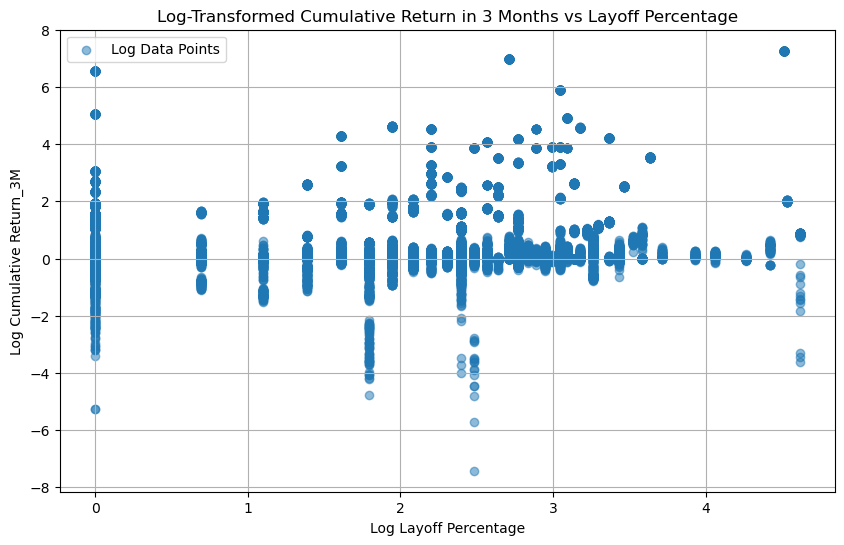

In [157]:
# 上图明显比例不合适，我们取个对数

import numpy as np

# 对裁员比例和收益率取对数（加 1 防止 log(0) 的问题）
merged_data['Log_Layoff_Percentage'] = np.log1p(merged_data['Layoff_Percentage'])
merged_data['Log_Cumulative_Return_3M'] = np.log1p(y4)

# 绘制对数变换后的数据
plt.figure(figsize=(10, 6))
plt.scatter(merged_data['Log_Layoff_Percentage'], merged_data['Log_Cumulative_Return_3M'], alpha=0.5, label='Log Data Points')
plt.xlabel('Log Layoff Percentage')
plt.ylabel('Log Cumulative Return_3M')
plt.title('Log-Transformed Cumulative Return in 3 Months vs Layoff Percentage')
plt.legend()
plt.grid(True)

plt.savefig('Log-Transformed Cumulative Return in 3 Months vs Layoff Percentage.png', dpi = 300)
plt.show()


In [148]:
print(merged_data.columns)

Index(['Unnamed: 0', 'Company', 'Location', '# Laid Off', 'Date_x', '%',
       'Source', 'Stage', '$ Raised', 'Country', 'Date Added', 'tickers',
       'Date_y', 'Value', 'Daily_Return', 'Layoff_Event', 'Event_Window',
       'Layoff_Percentage', 'Cumulative_Return', 'Quarter_Continuous',
       'Log_Layoff_Percentage', 'Log_Cumulative_Return',
       'Cumulative_Return_3M', 'Lag_-10', 'Lag_-9', 'Lag_-8', 'Lag_-7',
       'Lag_-6', 'Lag_-5', 'Lag_-4', 'Lag_-3', 'Lag_-2', 'Lag_-1', 'Lag_0',
       'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5', 'Lag_6', 'Lag_7', 'Lag_8',
       'Lag_9', 'Lag_10', 'Layoff_Timing_Interaction'],
      dtype='object')


In [151]:
# Refine event window with multiple lags and leads
for lag in range(-10, 11):
    merged_data[f'Lag_{lag}'] = (merged_data['Date_y'] == (merged_data['Date_x'] + pd.Timedelta(days=lag))).astype(int)

# Interaction term: Layoff_Percentage x Event_Window
merged_data['Layoff_Timing_Interaction'] = merged_data['Layoff_Percentage'] * merged_data['Event_Window']

# Update regression with refined variables
X_refined = merged_data[['Layoff_Percentage', 'Layoff_Timing_Interaction', 'Quarter_Continuous']]
X_refined = sm.add_constant(X_refined)
y_refined = merged_data['Cumulative_Return']

ols_refined = sm.OLS(y_refined, X_refined).fit()
print(ols_refined.summary())

                            OLS Regression Results                            
Dep. Variable:      Cumulative_Return   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     688.8
Date:                Mon, 09 Dec 2024   Prob (F-statistic):          5.10e-291
Time:                        17:33:15   Log-Likelihood:            -1.3528e+05
No. Observations:               22370   AIC:                         2.706e+05
Df Residuals:                   22367   BIC:                         2.706e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [144]:
import statsmodels.api as sm

# 构建模型数据
model_data = merged_data.copy()
model_data = model_data.dropna(subset=['Log_Cumulative_Return', 'Log_Layoff_Percentage', 'Quarter_Continuous', '$ Raised'])

# 确保相关列的数据类型正确
model_data['Log_Layoff_Percentage'] = model_data['Log_Layoff_Percentage'].astype(float)
model_data['Log_Cumulative_Return'] = model_data['Log_Cumulative_Return'].astype(float)
model_data['$ Raised'] = model_data['$ Raised'].astype(float)

# 因变量: Log_Cumulative_Return
Y = model_data['Log_Cumulative_Return']

# 自变量: Log_Layoff_Percentage 和控制变量
X = model_data[['Log_Layoff_Percentage', 'Quarter_Continuous', '$ Raised']]  # 添加其他变量如 'Quarter_Continuous'
X = sm.add_constant(X)  # 添加常数项

# 回归模型
ols_model = sm.OLS(Y, X).fit()
print(ols_model.summary())


                              OLS Regression Results                             
Dep. Variable:     Log_Cumulative_Return   R-squared:                       0.019
Model:                               OLS   Adj. R-squared:                  0.019
Method:                    Least Squares   F-statistic:                     143.6
Date:                   Mon, 09 Dec 2024   Prob (F-statistic):           3.98e-92
Time:                           16:58:07   Log-Likelihood:                -36794.
No. Observations:                  21977   AIC:                         7.360e+04
Df Residuals:                      21973   BIC:                         7.363e+04
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
